# VIT-TINY_Training_From_Scratch_CE_Only

*Configuration*  
- Input resolution: *32*  
- Patch size: *4*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 5M  
  - Curriculum: 60 epochs  
  - 🎯 *Accuracy:* 73.58%

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from transformers import ViTConfig, ViTForImageClassification
from tqdm.auto import tqdm
import random

# ----------------------------------------
# 1. Setup
# ----------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1

# reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# CIFAR-10 stats
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# ----------------------------------------
# 2. Data
# ----------------------------------------
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# download + split
full_ds = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size = int(0.1 * len(full_ds))
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(
    full_ds, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
# use clean transforms for val
val_ds.dataset.transform = val_tf

test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)

# loaders
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=True)

# ----------------------------------------
# 3. Model: ViT-Tiny from scratch at 32×32
# ----------------------------------------
vit_config = ViTConfig(
    image_size=32,
    patch_size=4,
    hidden_size=192,
    num_hidden_layers=12,
    num_attention_heads=3,
    intermediate_size=768,
    num_labels=10,
    hidden_dropout_prob =.1,
    classifier_dropout_prob=.1
)
model = ViTForImageClassification(vit_config).to(device)
if use_dp:
    model = nn.DataParallel(model)

# ----------------------------------------
# 4. Optimizer
# ----------------------------------------
no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in model.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in model.named_parameters() if     any(nd in n for nd in no_decay)]

optimizer = optim.AdamW([
    {"params": decay_params,   "weight_decay": 1e-4},
    {"params": nodecay_params, "weight_decay": 0.0},
], lr=3e-4)
# optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# ----------------------------------------
# 5. Helper: evaluation
# ----------------------------------------
def eval_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs)
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100.0 * correct / total

# ----------------------------------------
# 6. Training loop
# ----------------------------------------
epochs = 60
best_val_acc = 0.0
save_path = 'best_vit_tiny_cifar10.pth'

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = correct = total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(pixel_values=imgs, labels=labels)
        loss = outputs.loss
        # if DataParallel, loss is a tensor of size [N], so mean it
        if loss.dim() > 0:
            loss = loss.mean()
        loss.backward()
        optimizer.step()

        # stats
        total_loss += loss.item() * labels.size(0)
        preds = outputs.logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(
            loss=total_loss/total,
            acc=100.0*correct/total
        )

    train_acc = 100.0 * correct / total
    val_acc   = eval_model(model, val_loader)

    print(f" → Epoch {epoch:02d}: Train Acc {train_acc:.2f}% | Val Acc {val_acc:.2f}%")

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)

# ----------------------------------------
# 7. Final Test
# ----------------------------------------
model.load_state_dict(torch.load(save_path))
test_acc = eval_model(model, test_loader)
print(f"\n🎯 Final ViT-Tiny CIFAR-10 Test Acc: {test_acc:.2f}%")

# VIT-TINY_Training_From_Scratch_CE+CL_Only

*Configuration*  
- Input resolution: *16-20-24-28-32*  
- Patch size: *4*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 5M  
  - Curriculum: 10 Epochs per resolution stage  
  - 🎯 *Accuracy:* 79.80%

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import (
    ViTConfig,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm
import random

# Setup & Seeding for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# Initial transform to split dataset
init_tf = transforms.ToTensor()
dataset_full = datasets.CIFAR10('./data', train=True, download=True, transform=init_tf)
val_size = int(0.1 * len(dataset_full))
train_size = len(dataset_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 128

# Precompute DataLoaders for each resolution
stages = [(r) for r in [(12, 10), (16, 10), (20, 10), (24, 15), (28, 10), (32, 10)]]
dataloader_dict = {}

for resolution, _ in stages:
    train_tf = transforms.Compose([
        transforms.RandomCrop(resolution, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=False, transform=train_tf)
    val_set   = datasets.CIFAR10('./data', train=True, download=False, transform=val_tf)

    train_loader = DataLoader(Subset(train_set, train_ds.indices), batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(Subset(val_set, val_ds.indices), batch_size=batch_size,
                            shuffle=False, num_workers=0, pin_memory=True)

    dataloader_dict[resolution] = {
        'train': train_loader,
        'val': val_loader
    }

# Test loader (fixed resolution)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds = datasets.CIFAR10('./data', train=False, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# ViT-Tiny Classifier
class ViTTinyClassifier(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None):
        outputs = self.vit(
            pixel_values,
            interpolate_pos_encoding=True,
            return_dict=True
        )
        cls_output = outputs.last_hidden_state[:, 0]
        logits = self.classifier(cls_output)
        loss = None
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
        return {"logits": logits, "loss": loss}

# Instantiate model
tiny_config = ViTConfig(
    hidden_size=192,
    num_hidden_layers=12,
    num_attention_heads=3,
    intermediate_size=768,
    patch_size=2,
    image_size=32,
    num_labels=10,
    hidden_dropout_prob=0.1,
    classifier_dropout_prob=0.1
)
student = ViTTinyClassifier(tiny_config).to(device)
if use_dp:
    student = nn.DataParallel(student)

no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in student.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in student.named_parameters() if     any(nd in n for nd in no_decay)]

optimizer = optim.AdamW([
    {"params": decay_params,   "weight_decay": 1e-4},
    {"params": nodecay_params, "weight_decay": 0.0},
], lr=3e-4)


# Evaluation function
def eval_model(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(pixel_values=imgs)
            preds = outputs["logits"].argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Curriculum Training
for resolution, epochs in stages:
    print(f"\n=== Training at resolution {resolution}px ===")
    tr_loader = dataloader_dict[resolution]['train']
    vl_loader = dataloader_dict[resolution]['val']

    best_val_acc = 0
    no_improve = 0
    patience = 3

    for epoch in range(1, epochs + 1):
        student.train()
        train_correct = train_total = 0
        for imgs, labels in tqdm(tr_loader, desc=f"Epoch {epoch}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = student(pixel_values=imgs, labels=labels)
            loss = outputs["loss"]
            if loss is not None and loss.dim() > 0:
                loss = loss.mean()
            loss.backward()
            optimizer.step()

            preds = outputs["logits"].argmax(1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)

        train_acc = 100 * train_correct / train_total
        val_acc = eval_model(student, vl_loader)
        print(f"{resolution}px Ep{epoch}: Train {train_acc:.2f}%  Val {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            no_improve = 0
            torch.save(student.state_dict(), f'best_tiny_{resolution}px.pth')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"→ Early stopping at resolution {resolution}px")
                student.load_state_dict(torch.load(f'best_tiny_{resolution}px.pth'))
                break

    print(f"=> Stage {resolution}px best Val = {best_val_acc:.2f}%")

# Final test evaluation
student.load_state_dict(torch.load('best_tiny_32px.pth'))
final_test_acc = eval_model(student, test_loader)
print(f"\n🌟 Final ViT-Tiny Test Acc: {final_test_acc:.2f}%")

# VIT-SMALL-TEACHER_Training_From_Scratch

*Configuration*  
- Input resolution: *32*  
- Patch size: *4*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 22M  
  - Curriculum: 135 Epochs  
  - 🎯 *Accuracy:* 86.00%

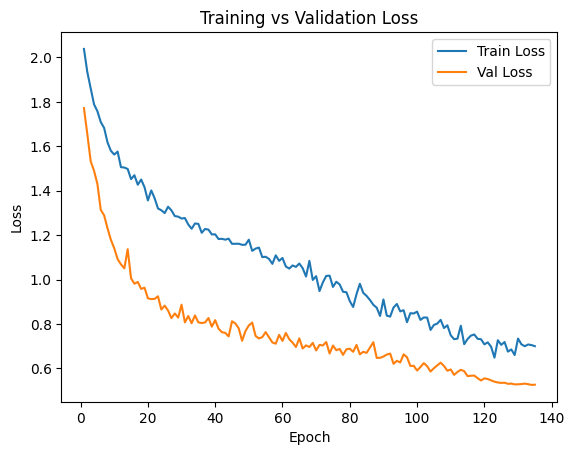
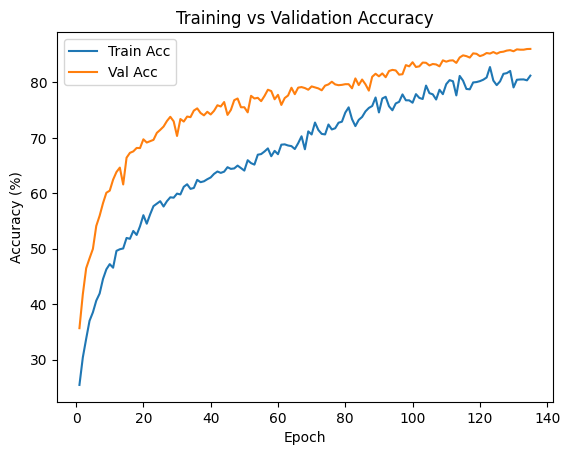

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    ViTForImageClassification,
    ViTPreTrainedModel,
    # ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm
import random
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
#Setup & Seeding to be able to reproduce results
#This seed is used for both KD and KD with CL

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)


#Helping generalize the model via mixup and cutmix
def mixup_data(x, y, alpha=0.1):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed = lam * x + (1 - lam) * x[idx]
    return mixed, y, y[idx], lam

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size(0)).to(x.device)
    target_a, target_b = y, y[rand_index]
    
    # Get bbox dimensions
    W, H = x.size(2), x.size(3)
    cut_ratio = np.sqrt(1.0 - lam)
    cut_w, cut_h = int(W * cut_ratio), int(H * cut_ratio)
    cx, cy = np.random.randint(W), np.random.randint(H)
    
    # Get bbox coordinates
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    
    # Apply cutmix
    x_mixed = x.clone()
    x_mixed[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # Adjust lambda to reflect actual area ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    return x_mixed, target_a, target_b, lam

teacher_config = ViTConfig(
    image_size=32,
    patch_size=4,
    num_labels=10,
    hidden_size=384,            # same as deit-small
    num_hidden_layers=12,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    stochastic_depth_prob=0.1
)

teacher = ViTForImageClassification(teacher_config).to(device)

teacher = nn.DataParallel(teacher)

# Improved data augmentation - using AutoAugment with reduced intensity
train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    AutoAugment(policy=AutoAugmentPolicy.CIFAR10),  # AutoAugment instead of RandAugment
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Reduced erasing
])
val_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

full = datasets.CIFAR10('./data', train=True, download=True, transform=train_tf)
val_size   = int(0.1 * len(full))
train_size = len(full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)
val_ds.dataset.transform = val_tf


batch_size = 128
# accum_steps = 2  # Gradient accumulation steps
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

ce_loss = nn.CrossEntropyLoss(label_smoothing=0.01)  # Reduced from 0.1

no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in teacher.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in teacher.named_parameters() if     any(nd in n for nd in no_decay)]

teacher_opt = optim.AdamW([
    {"params": decay_params,   "weight_decay": 2e-4},
    {"params": nodecay_params, "weight_decay": 0.0},
], lr=3e-4)

# Extended training with longer warmup
epochs = 135  # Increased from 30
total_steps = len(train_loader) * epochs 
# warmup_steps = int(0.1 * total_steps)  # Longer warmup (was 0.1)

sched = OneCycleLR(
    optimizer=teacher_opt,
    max_lr=4e-4,  # same as your earlier peak LR
    total_steps=len(train_loader) * epochs,
    pct_start=0.6,       # warmup portion (20%)
    anneal_strategy='cos',  # cosine annealing
    div_factor=20.0,     # initial_lr = max_lr / div_factor
    final_div_factor=5 # final_lr = initial_lr / final_div_factor
)

best_val, no_imp, patience = 0.0, 0, 150 # Increased patience
train_losses, val_losses = [], []
train_accs,    val_accs   = [], []

for ep in range(1, epochs+1):
    teacher.train(); tc = tt = 0
    train_loss_sum = 0.0
    for i, (imgs, labels) in enumerate(tqdm(train_loader, desc=f"Teacher FT {ep}/{epochs}")):
        imgs, labels = imgs.to(device), labels.to(device)
        
        # Randomly choose between mixup and cutmix - we are applying cutmix and mixup here
        if np.random.random() < 0.5:
            mixed, y_a, y_b, lam = mixup_data(imgs, labels, alpha=0.2)
        else:
            mixed, y_a, y_b, lam = cutmix_data(imgs, labels, alpha=1.0)
        
        # Forward pass for the teacher
        logits = teacher(mixed).logits #no need to 
        loss = lam * ce_loss(logits, y_a) + (1 - lam) * ce_loss(logits, y_b)
        
        train_loss_sum += loss.item()

        loss.backward()
        
        teacher_opt.step()
        
        sched.step()
        teacher_opt.zero_grad()
        # Calculating accuracy
        preds = logits.argmax(1)
        tc += lam * (preds == y_a).sum().item() + (1 - lam) * (preds == y_b).sum().item()
        tt += labels.size(0)
    train_loss = train_loss_sum / len(train_loader)
    train_acc = 100 * tc / tt

    # Validation of the teacher
    teacher.eval(); vc = vt = 0
    val_loss_sum = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # outputs = teacher(imgs)             # no interpolate_pos_encoding here
            logits  = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits
            loss    = ce_loss(logits, labels)   # per‐batch mean loss
            val_loss_sum += loss.item()
            p = logits.argmax(1)
            vc += (p == labels).sum().item(); vt += labels.size(0)
  
    val_loss = val_loss_sum / len(val_loader)
    val_acc = 100 * vc / vt

    print(f"FT Ep{ep}: Train {train_acc:.2f}%  Val {val_acc:.2f}%")

    # —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
    # Save a checkpoint every 10 epochs:
    if ep % 10 == 0:
        torch.save(
            teacher.state_dict(),
            f'teacher_epoch{ep:03d}.pth'
        )
        print(f"→ Saved checkpoint at epoch {ep}")
    # —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
    
    # Save best model
    if val_acc > best_val:
        best_val, no_imp = val_acc, 0
        print("savedagain")
        torch.save(teacher.state_dict(), 'small_p_4_correct_teacher_weights.pth')
    else:
        no_imp += 1
        if no_imp >= patience:
            print("→ teacher early stop"); break

    train_losses.append(train_loss)   # average loss over the epoch
    val_losses.append(val_loss)
    train_accs.append(train_acc)      # percentage, e.g. 72.34
    val_accs.append(val_acc)

# torch.save(teacher.state_dict(), "small_p_4_correct_teacher_weights.pth")
#Sotring the model - wont run it again Tauba

c_teacher = ViTForImageClassification(teacher_config).to(device)
c_teacher = nn.DataParallel(c_teacher)

c_teacher.load_state_dict(torch.load('small_p_4_correct_teacher_weights.pth'))
teacher.eval()
for p in teacher.parameters(): p.requires_grad_(False)


# Teacher: Final Test
test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

def eval_model(model, loader, is_student=False):
    model.eval(); c=t=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100*c/t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(c_teacher, test_loader):.2f}%")

plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure()
plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
plt.plot(range(1, epochs+1), val_accs,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# VIT-TINY_Training_KD_Only

*Configuration*  
- Input resolution: *16-20-24-28-32*  
- Patch size: *4*
- Teacher: *ViT SMALL*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 5M  
  - Curriculum: 10 Epochs per resolution stage  
  - 🎯 *Accuracy:* 81.35%


![Train Loss](train_overall_KD_ONLY.png)
![KL Divergence](KL_KD_only.png)
![Validation Accuracy](val_KD_only.png)


In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    DeiTForImageClassification,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# Initial transform to split dataset
init_tf = transforms.ToTensor()
dataset_full = datasets.CIFAR10('./data', train=True, download=True, transform=init_tf)
val_size = int(0.1 * len(dataset_full))
train_size = len(dataset_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 128

# Precompute DataLoaders for each resolution
stages = [(r) for r in [(32, 60)]]
dataloader_dict = {}

for resolution, _ in stages:
    train_tf = transforms.Compose([
        transforms.RandomCrop(resolution, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=False, transform=train_tf)
    val_set   = datasets.CIFAR10('./data', train=True, download=False, transform=val_tf)

    train_loader = DataLoader(Subset(train_set, train_ds.indices), batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(Subset(val_set, val_ds.indices), batch_size=batch_size,
                            shuffle=False, num_workers=0, pin_memory=True)

    dataloader_dict[resolution] = {
        'train': train_loader,
        'val': val_loader
    }

# Test loader (fixed resolution)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds = datasets.CIFAR10('./data', train=False, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here
class ViTWithDistillation(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.distill_token = nn.Parameter(torch.zeros(1,1,config.hidden_size))   #have to see if using a  non-zero init might help
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.distiller  = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None, teacher_logits=None,
                alpha=0.5, temperature=1.0):
        B = pixel_values.size(0)
        embeds = self.vit.embeddings(pixel_values, interpolate_pos_encoding=True)
        cls_emb   = embeds[:, :1, :]
        patch_emb = embeds[:, 1:, :]
        dist_tok  = self.distill_token.expand(B, -1, -1)
        x = torch.cat([cls_emb, dist_tok, patch_emb], dim=1)
        x = self.vit.encoder(x)[0]
        cls_out, dist_out = x[:,0], x[:,1]
        logits     = self.classifier(cls_out)
        dist_logits= self.distiller(dist_out)

        output = {"logits": logits, "distill_logits": dist_logits}
        if labels is not None and teacher_logits is not None:
            loss_ce = F.cross_entropy(logits, labels)
            loss_kd = F.kl_div(
                F.log_softmax(dist_logits/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ) * (temperature**2)
            output["loss"] = (1-alpha)*loss_ce + alpha*loss_kd
        return output

# Improved Teacher: Pretrained & Adapted DeiT → Fine‑tune on CIFAR‑10
# Using DeiT-small instead of tiny for increased capacity

teacher_config = ViTConfig(
    image_size=32,
    patch_size=4,
    num_labels=10,
    hidden_size=384,
    num_hidden_layers=12,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    stochastic_depth_prob=0.1
)
teacher = ViTForImageClassification(teacher_config).to(device)
teacher = nn.DataParallel(teacher)  
#Storing the model - wont run it again Tauba
ckpt = '/root/Deep_Learning_Project/small_p_4_correct_teacher_weights.pth'
state = torch.load(ckpt, map_location=device)
teacher.load_state_dict(state)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# no_decay = ["bias", "LayerNorm.weight"]
# decay_params = [p for n,p in teacher.named_parameters() if not any(nd in n for nd in no_decay)]
# nodecay_params = [p for n,p in teacher.named_parameters() if     any(nd in n for nd in no_decay)]

# teacher_opt = optim.AdamW([
#     {"params": decay_params,   "weight_decay": 1e-4},
#     {"params": nodecay_params, "weight_decay": 0.0},
# ], lr=4e-4)


def eval_model(model, loader, is_student=False):
    model.eval(); c=t=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100*c/t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(teacher, test_loader):.2f}%")

# Student: KD + Curriculum
student_config = ViTConfig(
    hidden_size=192,
    num_hidden_layers=12,
    num_attention_heads=3,
    intermediate_size=768,
    patch_size=4,
    image_size=32,
    num_labels=10,
    hidden_dropout_prob=.1,
    classifier_dropout_prob=.1
)
student = ViTWithDistillation(student_config).to(device)
student = nn.DataParallel(student)

alpha, temperature = 0.5, 4.0
stages = [(r,60) for r in [32]]

no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in student.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in student.named_parameters() if     any(nd in n for nd in no_decay)]
    
for res, epochs in stages:
    print(f"\n=== Training at resolution {res}px ===")
    tr_loader = dataloader_dict[res]['train']
    vl_loader = dataloader_dict[res]['val']
    
    optimizer_s = optim.AdamW([
    {"params": decay_params,   "weight_decay": 1e-4},
    {"params": nodecay_params, "weight_decay": 0.0},], lr=3e-4)
    
    best_stage, no_imp_s, pat_s = 0.0, 0, 3

    for e in range(1, epochs+1):
        student.train(); tc=tt=kl_sum=kl_cnt=0
        for imgs, labels in tqdm(tr_loader, desc=f"Stu {res}px Ep{e}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_s.zero_grad()
            teacher_out = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits
            out = student(pixel_values=imgs, labels=labels,
                          teacher_logits=teacher_out,
                          alpha=alpha, temperature=temperature)
            loss = out["loss"]
            if loss.dim()>0: loss = loss.mean()
            loss.backward(); optimizer_s.step()
            preds = out["logits"].argmax(1)
            tc += (preds==labels).sum().item(); tt += labels.size(0)
            kl_sum += F.kl_div(
                F.log_softmax(out["distill_logits"]/temperature,dim=1),
                F.softmax(teacher_out/temperature,dim=1),
                reduction='batchmean'
            ).item()
            kl_cnt += 1

        tr_acc = 100*tc/tt; kl = kl_sum/kl_cnt
        vl_acc = eval_model(student, vl_loader, True)
        print(f"{res}px Ep{e}: Train {tr_acc:.2f}%  Val {vl_acc:.2f}%  KL {kl:.4f}")
        if vl_acc > best_stage:
            best_stage, no_imp_s = vl_acc, 0
        # else:
        #     no_imp_s += 1
        #     if no_imp_s >= pat_s:
        #         print("→ student early stop"); break

    print(f"=> Stage {res}px best Val = {best_stage:.2f}%")

# ---------------------------
# 7. Final Student Test
# ---------------------------
print(f"\n🎯 Final Student Test Acc: {eval_model(student, test_loader, True):.2f}%")

# VIT-TINY_Training_KD+CL_Only

*Configuration*  
- Input resolution: *16-20-24-28-32*  
- Patch size: *4*
- Teacher: *ViT SMALL*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 5M  
  - Curriculum: 10 Epochs per resolution stage  
  - 🎯 *Accuracy:* 83.29%


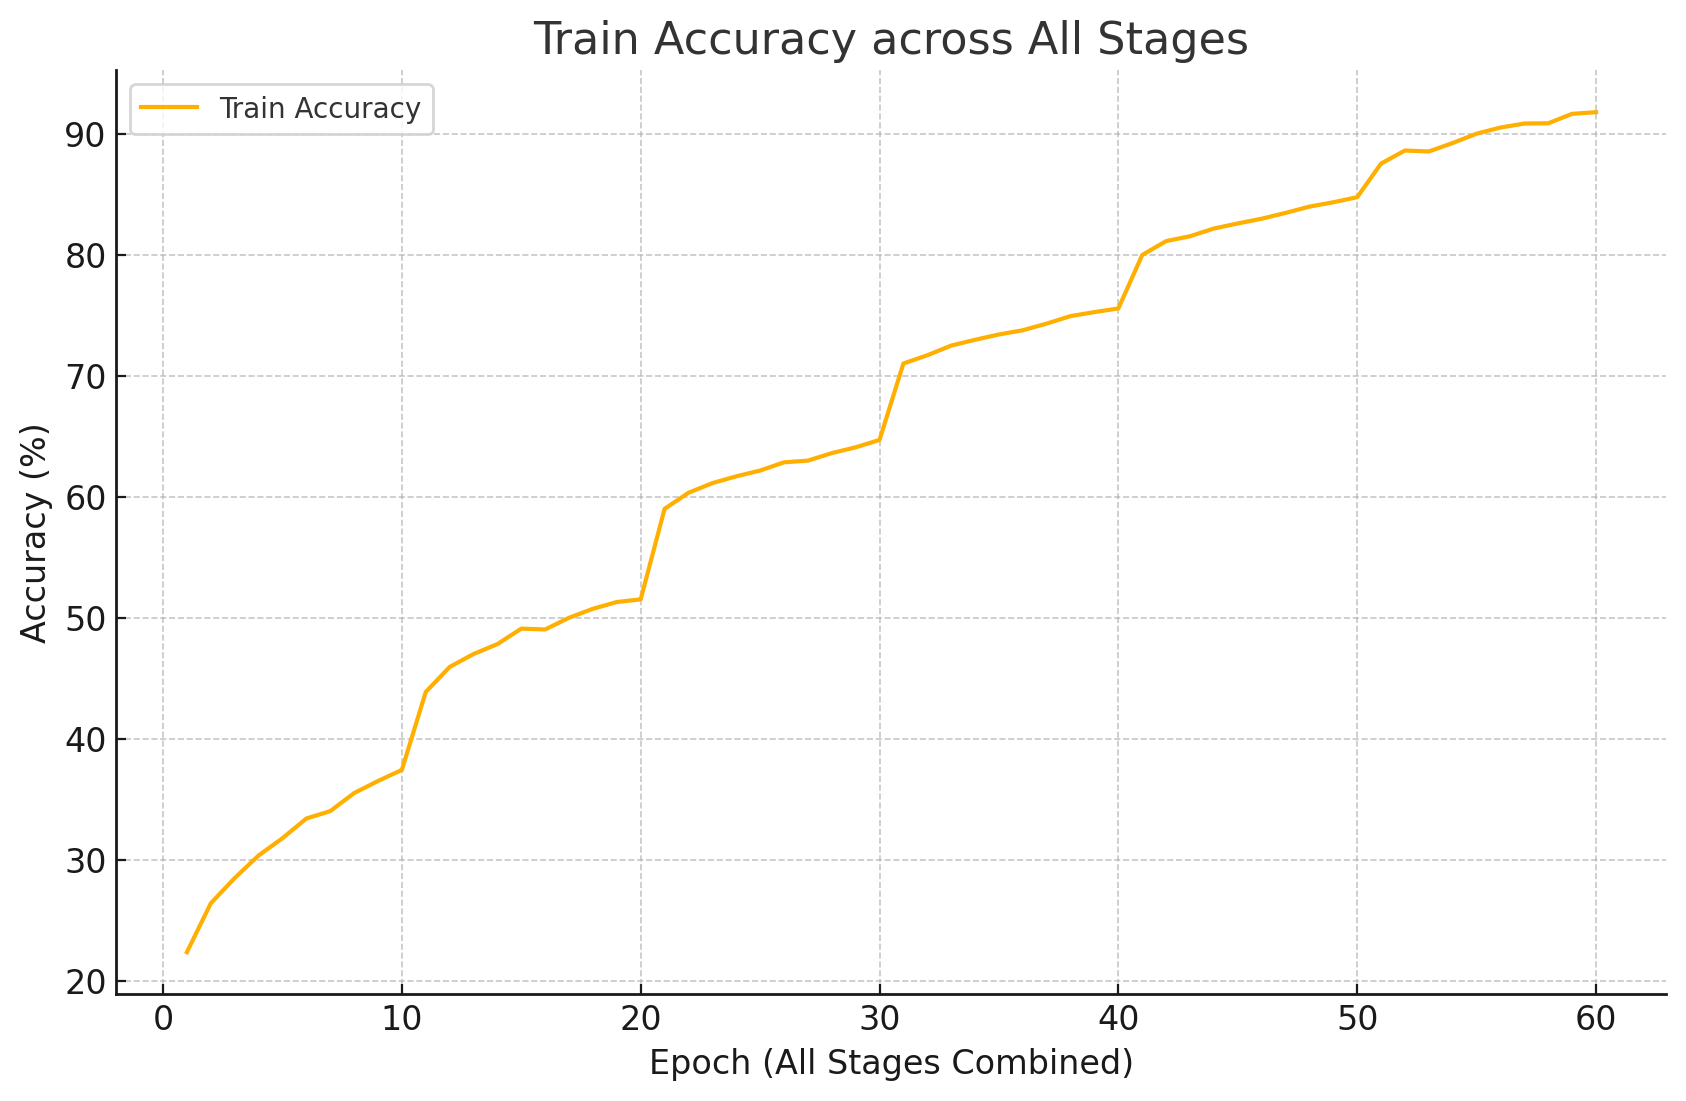 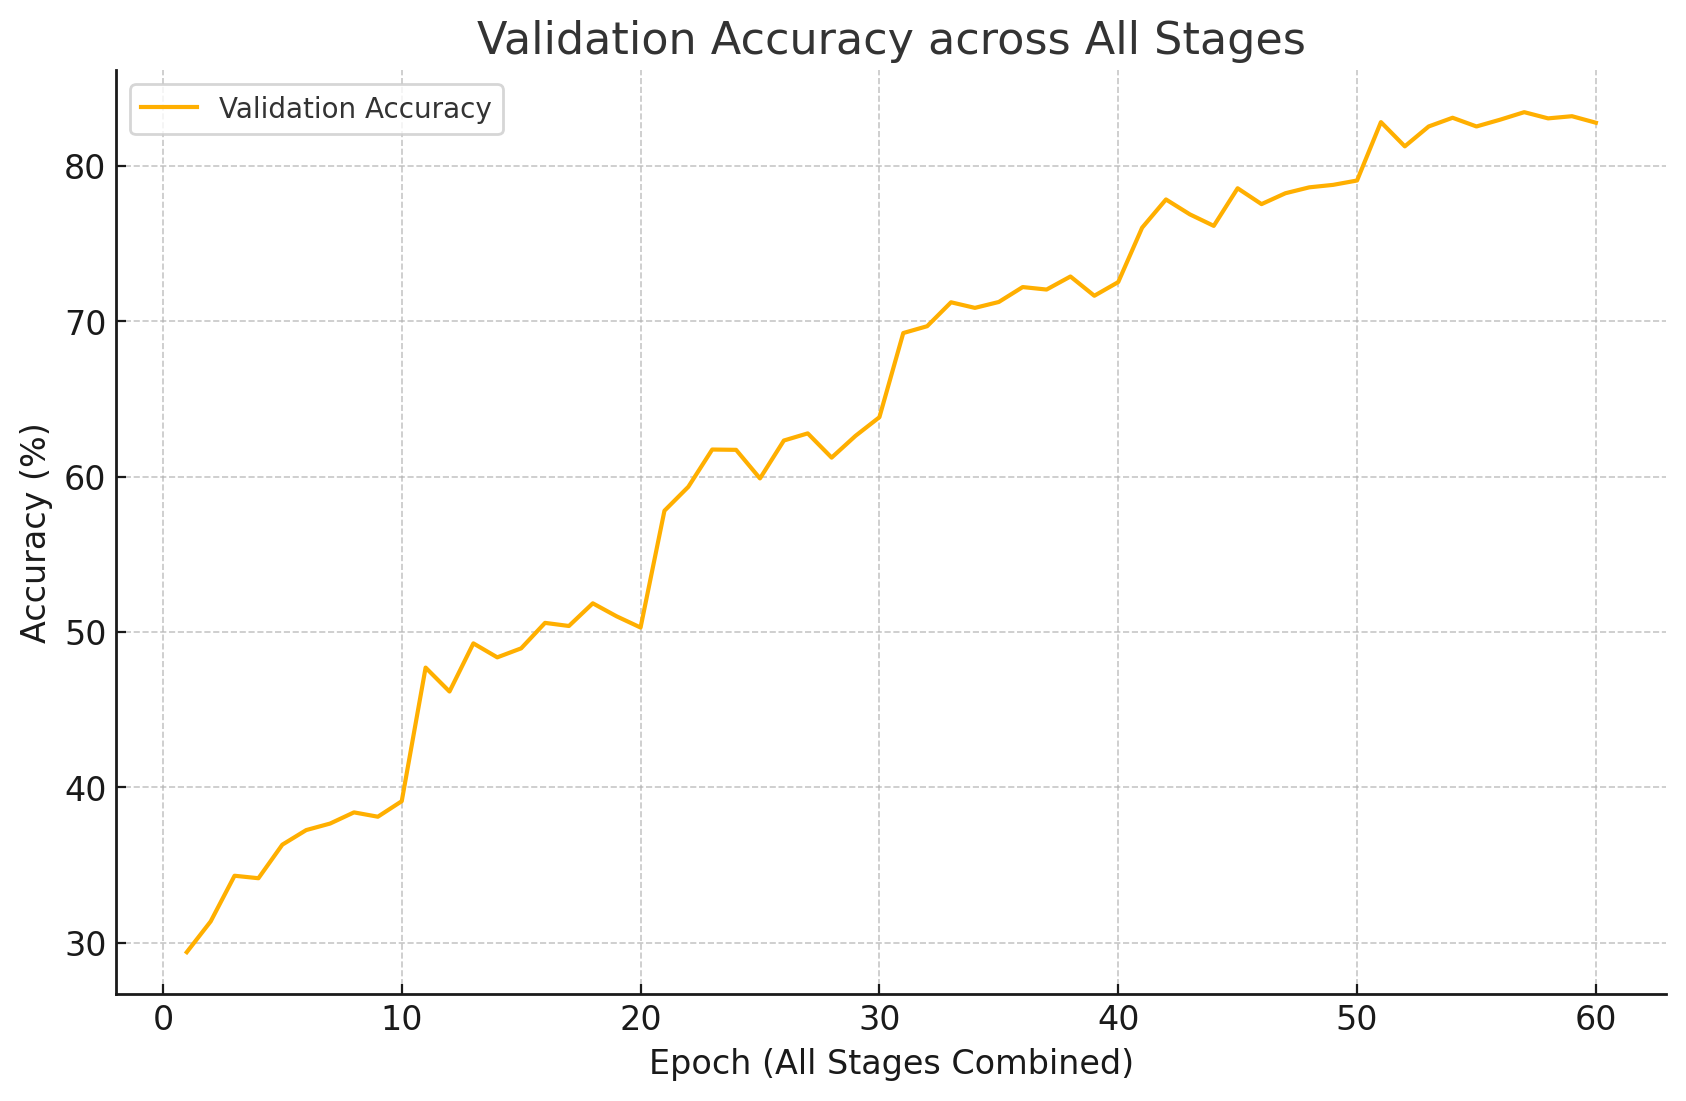 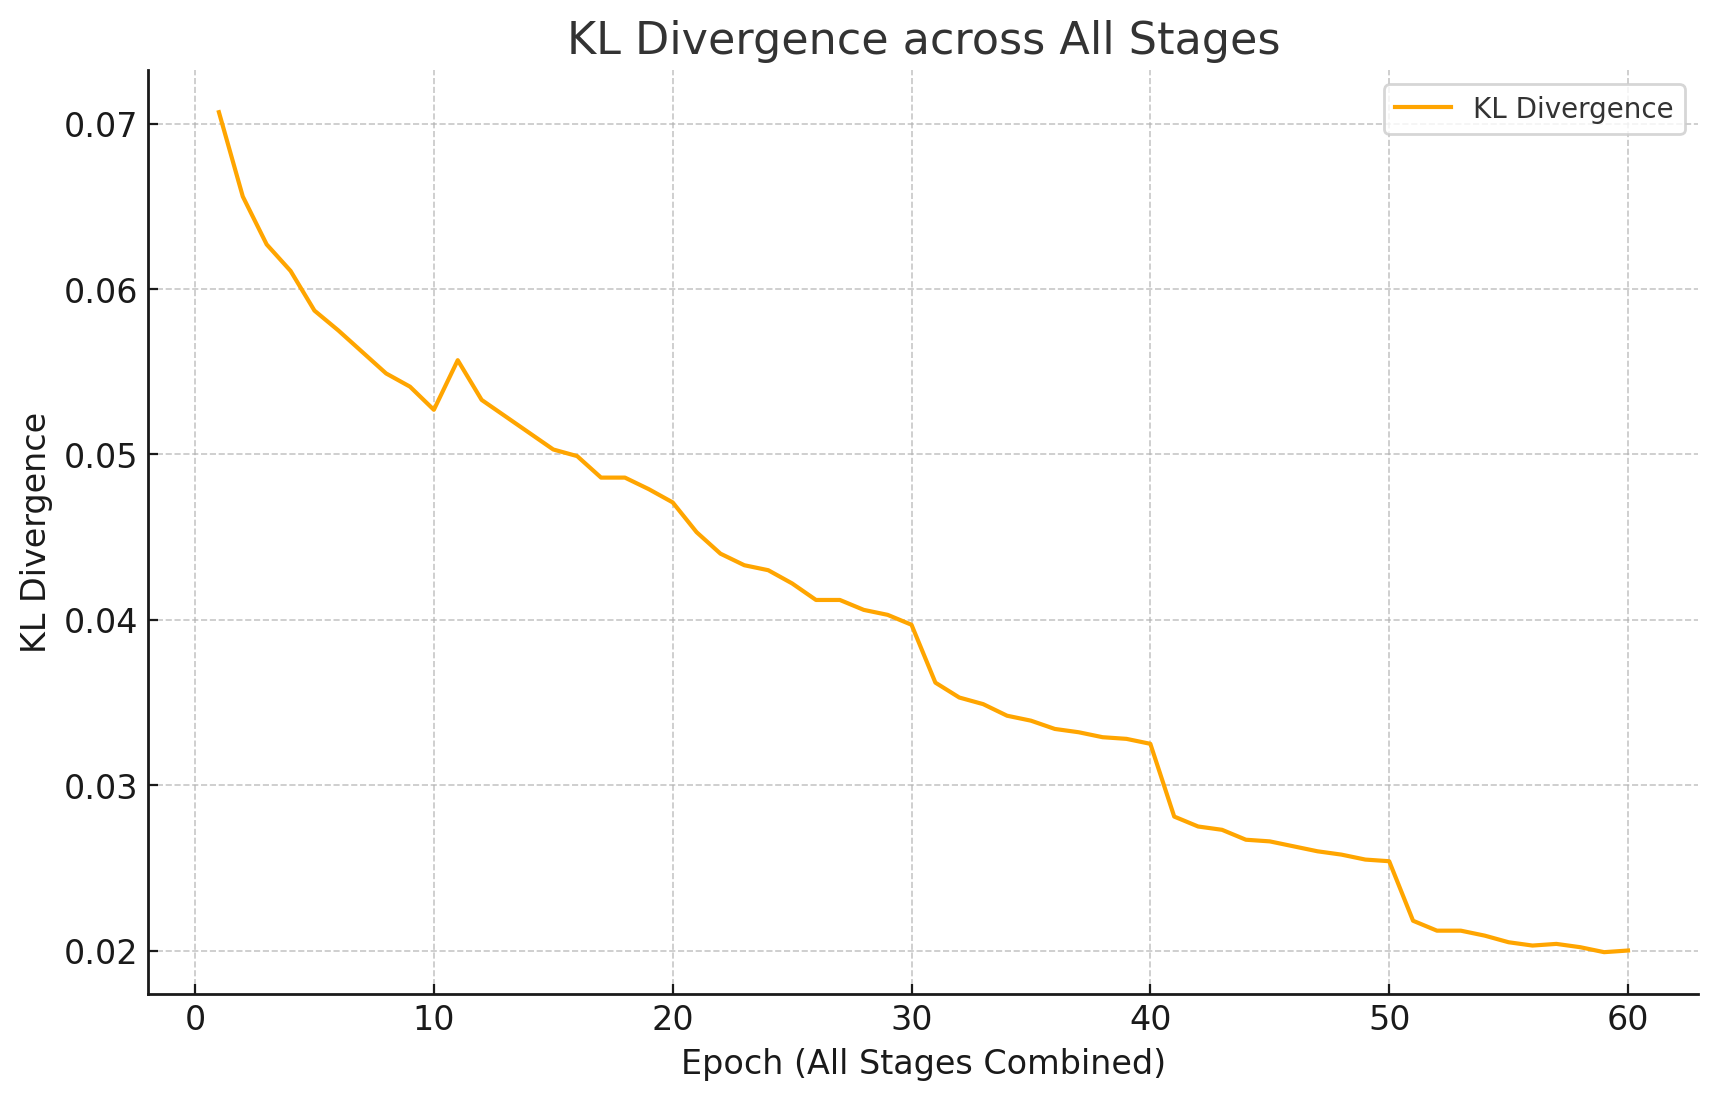

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    DeiTForImageClassification,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# Initial transform to split dataset
init_tf = transforms.ToTensor()
dataset_full = datasets.CIFAR10('./data', train=True, download=True, transform=init_tf)
val_size = int(0.1 * len(dataset_full))
train_size = len(dataset_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 128

# Precompute DataLoaders for each resolution
stages = [(r) for r in [(12, 10), (16, 10), (20, 10), (24, 10), (28, 10), (32, 10)]]
dataloader_dict = {}

for resolution, _ in stages:
    train_tf = transforms.Compose([
        transforms.RandomCrop(resolution, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=False, transform=train_tf)
    val_set   = datasets.CIFAR10('./data', train=True, download=False, transform=val_tf)

    train_loader = DataLoader(Subset(train_set, train_ds.indices), batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(Subset(val_set, val_ds.indices), batch_size=batch_size,
                            shuffle=False, num_workers=0, pin_memory=True)

    dataloader_dict[resolution] = {
        'train': train_loader,
        'val': val_loader
    }

# Test loader (fixed resolution)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds = datasets.CIFAR10('./data', train=False, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


#Using Student Class with distillation here - > we used huggingface library but we had to use a smaller ViT model and hence had to implement distill token here
class ViTWithDistillation(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config)
        self.distill_token = nn.Parameter(torch.zeros(1,1,config.hidden_size))   #have to see if using a  non-zero init might help
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.distiller  = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None, teacher_logits=None,
                alpha=0.5, temperature=1.0):
        B = pixel_values.size(0)
        embeds = self.vit.embeddings(pixel_values, interpolate_pos_encoding=True)
        cls_emb   = embeds[:, :1, :]
        patch_emb = embeds[:, 1:, :]
        dist_tok  = self.distill_token.expand(B, -1, -1)
        x = torch.cat([cls_emb, dist_tok, patch_emb], dim=1)
        x = self.vit.encoder(x)[0]
        cls_out, dist_out = x[:,0], x[:,1]
        logits     = self.classifier(cls_out)
        dist_logits= self.distiller(dist_out)

        output = {"logits": logits, "distill_logits": dist_logits}
        if labels is not None and teacher_logits is not None:
            loss_ce = F.cross_entropy(logits, labels)
            loss_kd = F.kl_div(
                F.log_softmax(dist_logits/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ) * (temperature**2)
            output["loss"] = (1-alpha)*loss_ce + alpha*loss_kd
        return output

# Improved Teacher: Pretrained & Adapted DeiT → Fine‑tune on CIFAR‑10
# Using DeiT-small instead of tiny for increased capacity

teacher_config = ViTConfig(
    image_size=32,
    patch_size=4,
    num_labels=10,
    hidden_size=384,
    num_hidden_layers=12,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    stochastic_depth_prob=0.1
)
teacher = ViTForImageClassification(teacher_config).to(device)
teacher = nn.DataParallel(teacher)  
#Storing the model - wont run it again Tauba
ckpt = '/root/Deep_Learning_Project/small_p_4_correct_teacher_weights.pth'
state = torch.load(ckpt, map_location=device)
teacher.load_state_dict(state)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# no_decay = ["bias", "LayerNorm.weight"]
# decay_params = [p for n,p in teacher.named_parameters() if not any(nd in n for nd in no_decay)]
# nodecay_params = [p for n,p in teacher.named_parameters() if     any(nd in n for nd in no_decay)]

# teacher_opt = optim.AdamW([
#     {"params": decay_params,   "weight_decay": 1e-4},
#     {"params": nodecay_params, "weight_decay": 0.0},
# ], lr=4e-4)


def eval_model(model, loader, is_student=False):
    model.eval(); c=t=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100*c/t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(teacher, test_loader):.2f}%")

# Student: KD + Curriculum
student_config = ViTConfig(
    hidden_size=192,
    num_hidden_layers=12,
    num_attention_heads=3,
    intermediate_size=768,
    patch_size=4,
    image_size=32,
    num_labels=10,
    hidden_dropout_prob=.1,
    classifier_dropout_prob=.1
)
student = ViTWithDistillation(student_config).to(device)
student = nn.DataParallel(student)

alpha, temperature = 0.5, 4.0
stages = [(r,10) for r in [12,16,20,24,28,32]]

no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in student.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in student.named_parameters() if     any(nd in n for nd in no_decay)]
    
for res, epochs in stages:
    print(f"\n=== Training at resolution {res}px ===")
    tr_loader = dataloader_dict[res]['train']
    vl_loader = dataloader_dict[res]['val']
    
    optimizer_s = optim.AdamW([
    {"params": decay_params,   "weight_decay": 1e-4},
    {"params": nodecay_params, "weight_decay": 0.0},], lr=3e-4)
    
    best_stage, no_imp_s, pat_s = 0.0, 0, 3

    for e in range(1, epochs+1):
        student.train(); tc=tt=kl_sum=kl_cnt=0
        for imgs, labels in tqdm(tr_loader, desc=f"Stu {res}px Ep{e}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_s.zero_grad()
            teacher_out = teacher(pixel_values=imgs, interpolate_pos_encoding=True).logits
            out = student(pixel_values=imgs, labels=labels,
                          teacher_logits=teacher_out,
                          alpha=alpha, temperature=temperature)
            loss = out["loss"]
            if loss.dim()>0: loss = loss.mean()
            loss.backward(); optimizer_s.step()
            preds = out["logits"].argmax(1)
            tc += (preds==labels).sum().item(); tt += labels.size(0)
            kl_sum += F.kl_div(
                F.log_softmax(out["distill_logits"]/temperature,dim=1),
                F.softmax(teacher_out/temperature,dim=1),
                reduction='batchmean'
            ).item()
            kl_cnt += 1

        tr_acc = 100*tc/tt; kl = kl_sum/kl_cnt
        vl_acc = eval_model(student, vl_loader, True)
        print(f"{res}px Ep{e}: Train {tr_acc:.2f}%  Val {vl_acc:.2f}%  KL {kl:.4f}")
        if vl_acc > best_stage:
            best_stage, no_imp_s = vl_acc, 0
        else:
            no_imp_s += 1
            if no_imp_s >= pat_s:
                print("→ student early stop"); break

    print(f"=> Stage {res}px best Val = {best_stage:.2f}%")

# ---------------------------
# 7. Final Student Test
# ---------------------------
print(f"\n🎯 Final Student Test Acc: {eval_model(student, test_loader, True):.2f}%")

# VIT-TINY_Training_KD+CL+SaliencyMaps_Only

*Configuration*  
- Input resolution: *16-20-24-28-32*  
- Patch size: *4*
- Teacher: *ViT SMALL*

---

### Models & Parameters

- *Student (ViT‑Tiny)*  
  - Parameters: 5M  
  - Curriculum: 10 Epochs per resolution stage  
  - 🎯 *Accuracy:* 84.29%

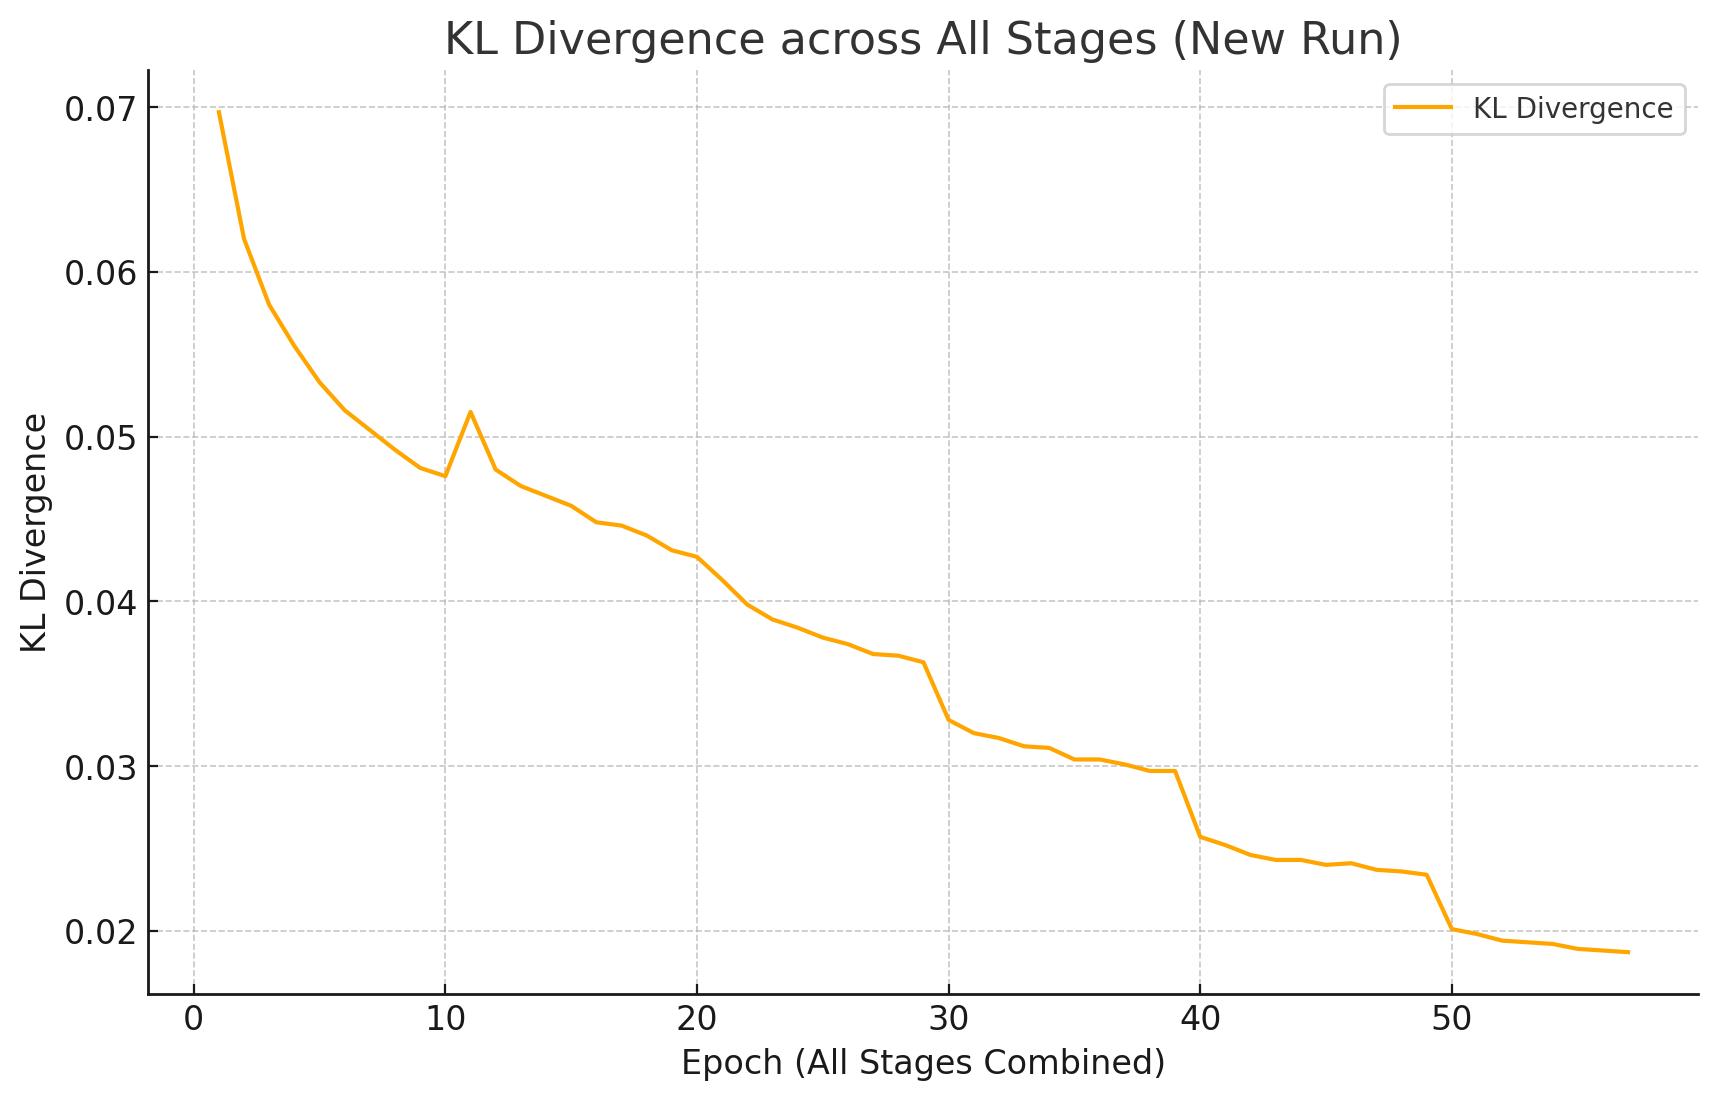 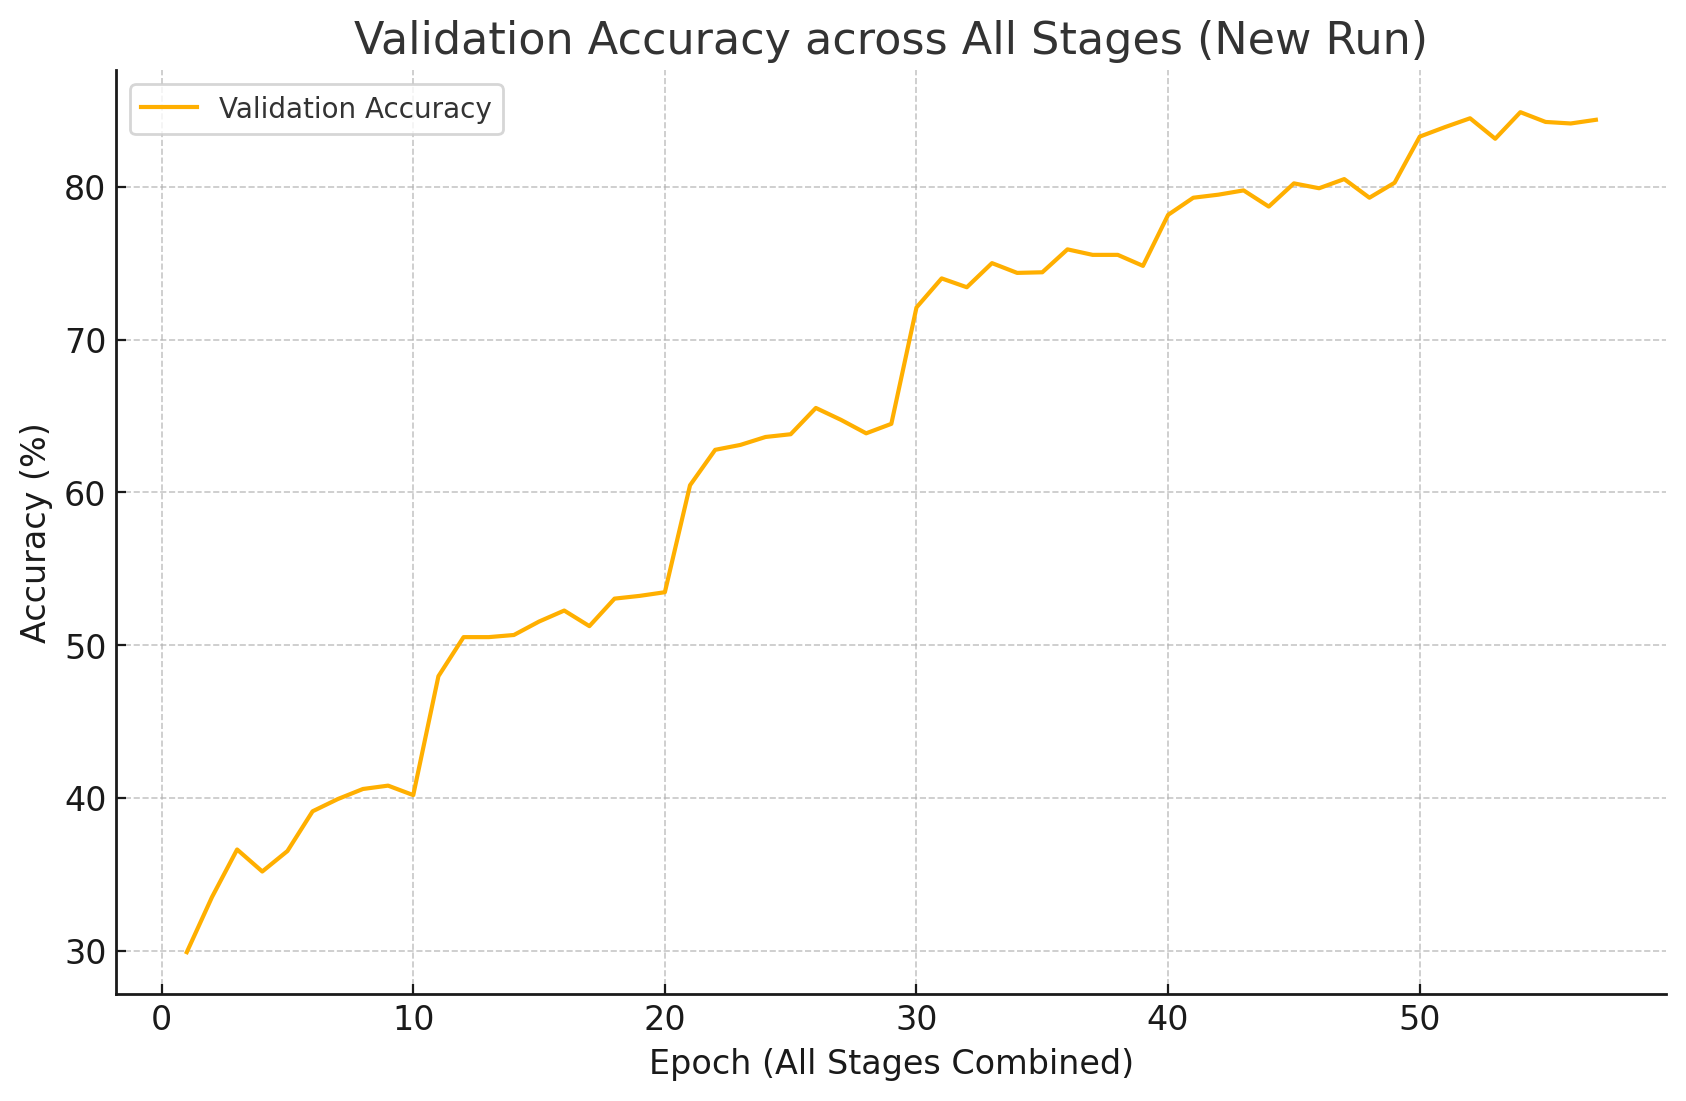 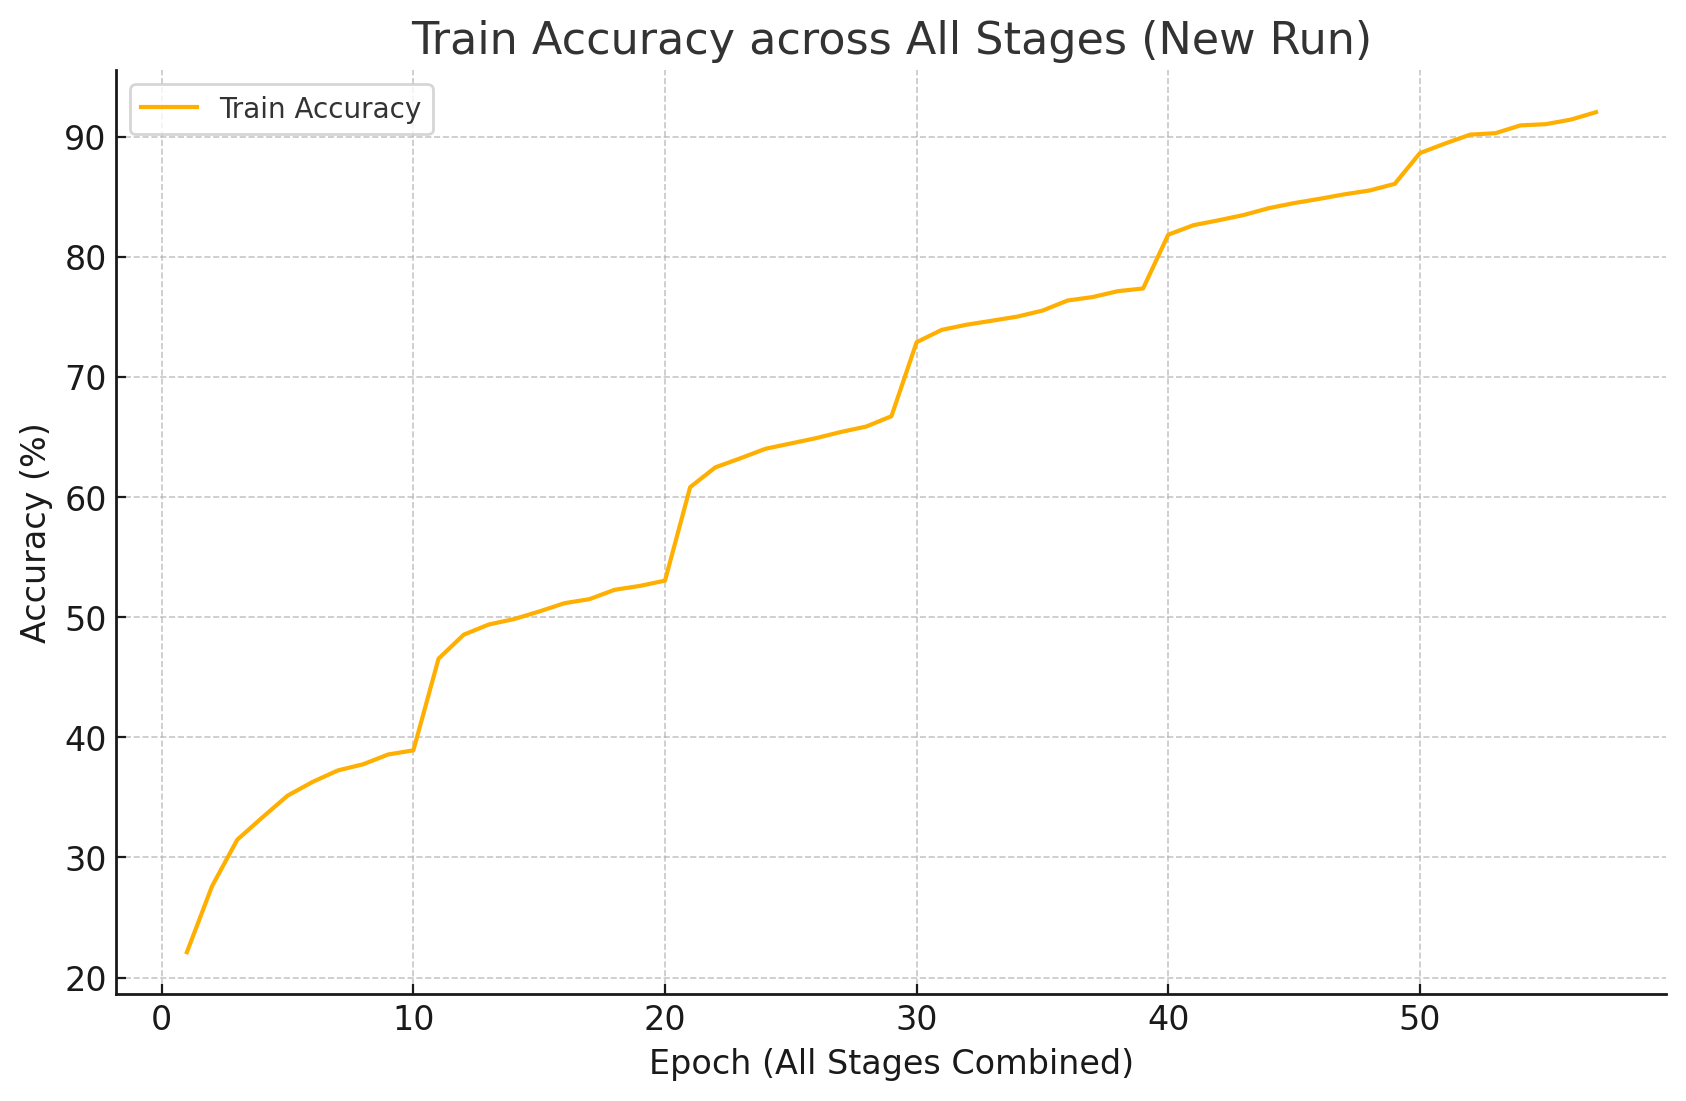

In [ ]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandomErasing
from transformers import (
    ViTConfig,
    DeiTForImageClassification,
    ViTPreTrainedModel,
    ViTModel,
    get_cosine_schedule_with_warmup
)
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
# Setup & Seeding
use_dp = torch.cuda.device_count() > 1
torch.manual_seed(42)
np.random.seed(42)

#Tranformation values as found online for CIFAR-10
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

# Initial transform to split dataset
init_tf = transforms.ToTensor()
dataset_full = datasets.CIFAR10('./data', train=True, download=True, transform=init_tf)
val_size = int(0.1 * len(dataset_full))
train_size = len(dataset_full) - val_size
train_ds, val_ds = torch.utils.data.random_split(
    dataset_full,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 128

# Precompute DataLoaders for each resolution
stages = [(r) for r in [(12, 10), (16, 10), (20, 10), (24, 10), (28, 10), (32, 10)]]
dataloader_dict = {}

for resolution, _ in stages:
    train_tf = transforms.Compose([
        transforms.RandomCrop(resolution, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    val_tf = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = datasets.CIFAR10('./data', train=True, download=False, transform=train_tf)
    val_set   = datasets.CIFAR10('./data', train=True, download=False, transform=val_tf)

    train_loader = DataLoader(Subset(train_set, train_ds.indices), batch_size=batch_size,
                              shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(Subset(val_set, val_ds.indices), batch_size=batch_size,
                            shuffle=False, num_workers=0, pin_memory=True)

    dataloader_dict[resolution] = {
        'train': train_loader,
        'val': val_loader
    }

# Test loader (fixed resolution)
test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_ds = datasets.CIFAR10('./data', train=False, transform=test_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)





def plot_epoch_attention(img, t_attn, s_attn, epoch, out_dir="attention_viz"):
    """
    img:       Tensor [3,H,W] in normalized space
    t_attn:    Tensor [H,W]  teacher heatmap in [0,1]
    s_attn:    Tensor [H,W]  student heatmap in [0,1]
    """
    os.makedirs(out_dir, exist_ok=True)
    # un‐normalize
    im = img.cpu().permute(1,2,0).numpy()*std + mean
    
    fig,axes = plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(im);    axes[0].set_title("Original");    axes[0].axis("off")
    axes[1].imshow(im);    axes[1].imshow(t_attn.cpu(), cmap="jet", alpha=0.5)
    axes[1].set_title("Teacher"); axes[1].axis("off")
    axes[2].imshow(im);    axes[2].imshow(s_attn.cpu(), cmap="jet", alpha=0.5)
    axes[2].set_title("Student"); axes[2].axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.tight_layout()
    plt.savefig(f"{out_dir}/epoch{epoch:02d}.png")
    plt.close(fig)

# Attention processing functions
def process_attention(attentions, layer_idx, has_distill=True):
    """Process attention maps with normalization"""
    attn = attentions[layer_idx].mean(dim=1)  # Average over heads
    cls_attn = attn[:, 0, 2:] if has_distill else attn[:, 0, 1:]
    H = W = int(math.sqrt(cls_attn.shape[-1]))
    spatial_attn = cls_attn.reshape(-1, H, W)
    
    # Min-max normalization
    min_val = spatial_attn.amin(dim=(1,2), keepdim=True)
    max_val = spatial_attn.amax(dim=(1,2), keepdim=True)
    spatial_attn = (spatial_attn - min_val) / (max_val - min_val + 1e-8)
        
    return spatial_attn

def multi_layer_attention_loss(teacher_outputs, student_outputs):
    """Calculate multi-layer attention alignment loss"""
    total_loss = 0.0
    valid_layers = 0
    layer_indices = list(range(12)) 
    
    teacher_attentions = teacher_outputs.attentions
    student_attentions = student_outputs["attentions"]
    
    for layer_idx in layer_indices:
        try:
            t_attn = process_attention(teacher_attentions, layer_idx,has_distill=False)
            s_attn = process_attention(student_attentions, layer_idx)
            
            # Ensure same spatial dimensions
            if t_attn.shape[-2:] != s_attn.shape[-2:]:
                s_attn = F.interpolate(s_attn.unsqueeze(1), 
                                      size=t_attn.shape[-2:], 
                                      mode='bilinear').squeeze(1)
            
            total_loss += F.mse_loss(s_attn, t_attn.detach())
            valid_layers += 1
        except (IndexError, AttributeError):
            continue
            
    return total_loss / valid_layers if valid_layers > 0 else 0.0

# Student Model

class ViTWithDistillation(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.vit = ViTModel(config, add_pooling_layer=False)
        self.distill_token = nn.Parameter(torch.zeros(1,1,config.hidden_size))
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.distiller = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, pixel_values, labels=None, teacher_logits=None, alpha=0.5, temperature=1.0):
        B = pixel_values.size(0)
        embeds = self.vit.embeddings(pixel_values, interpolate_pos_encoding=True)
        cls_emb = embeds[:, :1, :]
        patch_emb = embeds[:, 1:, :]
        dist_tok = self.distill_token.expand(B, -1, -1)
        x = torch.cat([cls_emb, dist_tok, patch_emb], dim=1)
        encoder_outputs = self.vit.encoder(x, output_attentions=True)
        x = encoder_outputs.last_hidden_state
        cls_out, dist_out = x[:,0], x[:,1]
        logits = self.classifier(cls_out)
        dist_logits = self.distiller(dist_out)

        output = {
            "logits": logits,
            "distill_logits": dist_logits,
            "attentions": encoder_outputs.attentions
        }
        if labels is not None and teacher_logits is not None:
            loss_ce = F.cross_entropy(logits, labels)
            loss_kd = F.kl_div(
                F.log_softmax(dist_logits/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ) * (temperature**2)
            output["loss"] = (1-alpha)*loss_ce + alpha*loss_kd
        return output

# Load pre-trained teacher
teacher_config = ViTConfig(
    image_size=32,
    patch_size=4,
    num_labels=10,
    hidden_size=384,
    num_hidden_layers=12,
    num_attention_heads=6,
    intermediate_size=1536,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    stochastic_depth_prob=0.1,
    output_attentions=True
)
teacher = ViTForImageClassification(teacher_config).to(device)
teacher = nn.DataParallel(teacher)  
#Storing the model - wont run it again Tauba
ckpt = '/root/Deep_Learning_Project/small_p_4_correct_teacher_weights.pth'
state = torch.load(ckpt, map_location=device)
teacher.load_state_dict(state)
teacher.eval()
for p in teacher.parameters():
    p.requires_grad_(False)

# Student training parameters
# batch_size = 128
def eval_model(model, loader, is_student=False):
    model.eval(); c=t=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            if is_student:
                logits = model(pixel_values=imgs)["logits"]
            else:
                logits = model(pixel_values=imgs, interpolate_pos_encoding=True).logits
            preds = logits.argmax(1)
            c += (preds==labels).sum().item(); t += labels.size(0)
    return 100*c/t

print(f"\n🎯 Final Teacher Test Acc: {eval_model(teacher, test_loader):.2f}%")


student_config = ViTConfig(
    hidden_size=192,
    num_hidden_layers=12,
    num_attention_heads=3,
    intermediate_size=768,
    patch_size=4,
    image_size=32,
    num_labels=10,
    hidden_dropout_prob=.1,
    classifier_dropout_prob=.1,
    output_attentions=True
)

# student_config = ViTConfig(
#     hidden_size=128,
#     num_hidden_layers=4,
#     num_attention_heads=4,
#     intermediate_size=256,
#     patch_size=2,
#     image_size=32,
#     num_labels=10,
#     output_attentions=True
# )

student = ViTWithDistillation(student_config).to(device)
student = nn.DataParallel(student)

alpha_att = 0.8  # Attention loss weight
alpha, temperature = 0.5, 4.0
stages = [(r,10) for r in [12,16,20,24,28,32]]


no_decay = ["bias", "LayerNorm.weight"]
decay_params = [p for n,p in student.named_parameters() if not any(nd in n for nd in no_decay)]
nodecay_params = [p for n,p in student.named_parameters() if     any(nd in n for nd in no_decay)]

# Student training loop
for res, epochs in stages:
    print(f"\n=== Training at resolution {res}px ===")
    tr_loader = dataloader_dict[res]['train']
    vl_loader = dataloader_dict[res]['val']
    
    optimizer_s = optim.AdamW([
    {"params": decay_params,   "weight_decay": 1e-4},
    {"params": nodecay_params, "weight_decay": 0.0},], lr=3e-4)
    
    best_stage, no_imp_s, pat_s = 0.0, 0, 3

    for e in range(1, epochs+1):
        student.train()
        tc = tt = kl_sum = kl_cnt = 0
        for imgs, labels in tqdm(tr_loader, desc=f"Stu {res}px Ep{e}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer_s.zero_grad()
            
            with torch.no_grad():
                teacher_outputs = teacher(pixel_values=imgs, interpolate_pos_encoding=True)
                teacher_logits = teacher_outputs.logits
                # teacher_attentions = teacher_outputs.attentions
                
            student_outputs = student(
                pixel_values=imgs,
                labels=labels,
                teacher_logits=teacher_logits,
                alpha=alpha,
                temperature=temperature
            )
            
            # Calculate losses
            loss = student_outputs["loss"]
            if loss.dim() > 0:       # i.e. shape = (n_gpus,)
                loss = loss.mean()   #
            loss_attn = multi_layer_attention_loss(teacher_outputs, student_outputs)
            # print(f"{loss_attn}")
            total_loss = loss + alpha_att * loss_attn
            
            total_loss.backward()
            optimizer_s.step()
            
            preds = student_outputs["logits"].argmax(1)
            tc += (preds == labels).sum().item()
            tt += labels.size(0)
            kl_sum += F.kl_div(
                F.log_softmax(student_outputs["distill_logits"]/temperature, dim=1),
                F.softmax(teacher_logits/temperature, dim=1),
                reduction='batchmean'
            ).item()
            kl_cnt += 1

        tr_acc = 100 * tc / tt
        kl = kl_sum / kl_cnt
        vl_acc = eval_model(student, vl_loader, True)
        print(f"{res}px Ep{e}: Train {tr_acc:.2f}%  Val {vl_acc:.2f}%  KL {kl:.4f}")
        
        if vl_acc > best_stage:
            best_stage, no_imp_s = vl_acc, 0
        else:
            no_imp_s += 1
            if no_imp_s >= pat_s:
                print("→ Student early stop")
                break

        # ←——— INSERT VISUALIZATION HERE ———→
        # grab one validation image
        val_imgs, val_lbls = next(iter(vl_loader))
        img = val_imgs[0]
        label = val_lbls[0].item()

        # forward with attentions
        with torch.no_grad():
            t_out = teacher(pixel_values=img.unsqueeze(0).to(device),interpolate_pos_encoding=True)
            s_out = student(pixel_values=img.unsqueeze(0).to(device))

        # extract & upsample
        layer_idx = -1
        t_map = process_attention(t_out.attentions, layer_idx,has_distill=False)[0]       # [H_patch,H_patch]
        s_map = process_attention(s_out["attentions"], layer_idx)[0]   # [H_patch,H_patch]

        t_map = F.interpolate(t_map.unsqueeze(0).unsqueeze(0),
                              size=img.shape[1:], mode='bilinear').squeeze()
        s_map = F.interpolate(s_map.unsqueeze(0).unsqueeze(0),
                              size=img.shape[1:], mode='bilinear').squeeze()

        plot_epoch_attention(img, t_map, s_map, epoch=e, out_dir=f"stage{res}px")

        # now print the per-stage best
        print(f"=> Stage {res}px best Val = {best_stage:.2f}%")

# Final evaluation
test_ds = datasets.CIFAR10('./data', train=False, transform=val_tf)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
print(f"\n🎯 Final Student Test Acc: {eval_model(student, test_loader, True):.2f}%")